The following notebook illustrates the steps/classes that can be chained to create complex pre-processing pipelines
The `preproc` package has 60+ classes for our task
Intermediate results are stored in RAM, which allows for fast processing. Theyare deleted once the processing is complete.


## Simple Processing pipeline

We will calculate the NDVI index for the uploaded image

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os

import solaris.preproc.pipesegment as pipesegment
import solaris.preproc.image as image
import solaris.preproc.sar as sar
import solaris.preproc.optical as optical
import solaris.preproc.label as label

/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework

In [2]:
plt.rcParams['figure.figsize'] = [4, 4]
datadir = r'//home//jupyter//solaris//solaris//data//preproc_tutorial'

In the next step we will initialize our pre-processing pipeline

In [3]:
mypipeline = (
    image.LoadImage(os.path.join(datadir, 'ms1.tif'))
    * sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
    
)

In [4]:
mypipeline()

### R1 
Since there was an error in the above code block, I tried to read it via `rasterio` & `osgeo` packages. 
Both returned a positive value. ie. they could read the meta information and also get the band information
So there should be some thing else wrong in the above code

> The error was for the following line of code 

> `* image.SaveImage(os.path.join(datadir, 'output1.tif'))`


In [5]:
import rasterio as rio

lidar_dem_path = '/home/jupyter/solaris/solaris/data/preproc_tutorial/ms1.tif'

with rio.open(lidar_dem_path) as lidar_dem:
    print(lidar_dem.bounds)
    print()
    print(lidar_dem.meta)

BoundingBox(left=593270.2919143771, bottom=5747357.40137748, right=593570.3064090556, top=5747657.4158721585)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 300, 'height': 300, 'count': 4, 'crs': CRS.from_epsg(32631), 'transform': Affine(1.0000483155950517, 0.0, 593270.2919143771,
       0.0, -1.0000483155950517, 5747657.4158721585)}


In [6]:
from osgeo import gdal

In [8]:
ds = gdal.Open(lidar_dem_path, gdal.GA_ReadOnly)
b1 = ds.GetRasterBand(0)

In [9]:
ds.GetRasterBand(3)

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7fca35fc31b0> >

Visible Spectrum


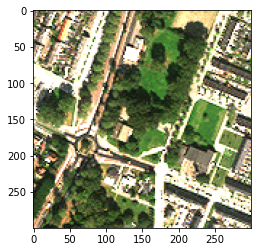

Normalized Difference Vegetation Index


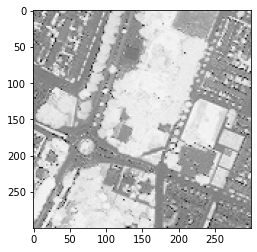

ms1: 1 bands, 300x300, float64, {'geotransform': (593270.2919143771, 1.0000483155950517, 0.0, 5747657.4158721585, 0.0, -1.0000483155950517), 'projection_ref': 'PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199...

        min       max      mean    median      std    pos  zero   neg  nan
0 -0.972502  0.997769  0.440329  0.430321  0.35757  83584   288  6128    0



In [10]:
# Removed the SaveImage line of code
# image.SaveImage(os.path.join(datadir, 'output1.tif'))
my_pipeline_with_output = (
    image.LoadImage(os.path.join(datadir, 'ms1.tif'))
    * image.ShowImage(bands=[2,1,0], vmin=0, vmax=250, caption='Visible Spectrum')
    * sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
    * image.ShowImage(caption='Normalized Difference Vegetation Index')
    * image.ImageStats()
)

my_pipeline_with_output()

One should always create re-usable classes 

In [11]:
class MyPipeline(pipesegment.PipeSegment):
    def __init__(self):
        super().__init__()
        self.feeder = (
            image.LoadImage(os.path.join(datadir, 'ms1.tif'))
            * sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
            #* image.SaveImage(os.path.join(datadir, 'output1.tif'))
        )

my_pipeline_instance = MyPipeline()
my_pipeline_instance()

In [12]:
class MyBestPipeline(pipesegment.PipeSegment):
    def __init__(self, input_path, output_path):
        super().__init__()
        load = image.LoadImage(input_path)
        ndvi = sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
        #save = image.SaveImage(output_path)
        self.feeder = load * ndvi #* save

my_input_path = os.path.join(datadir, 'ms1.tif')
my_output_path = os.path.join(datadir, 'output1.tif')
my_best_pipeline_instance = MyBestPipeline(my_input_path, my_output_path)
my_best_pipeline_instance()

## Branching 

We will now use pre-processing in our pipeline

We use a high-res panchormatic image & merge with a low-res color image to create a pan-sharpened satellite image (of high-res)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os

import solaris.preproc.pipesegment as pipesegment
import solaris.preproc.image as image
import solaris.preproc.sar as sar
import solaris.preproc.optical as optical
import solaris.preproc.label as label

plt.rcParams['figure.figsize'] = [4, 4]
datadir = '/home/jupyter/solaris/solaris/data/preproc_tutorial'

Low-res color imagery


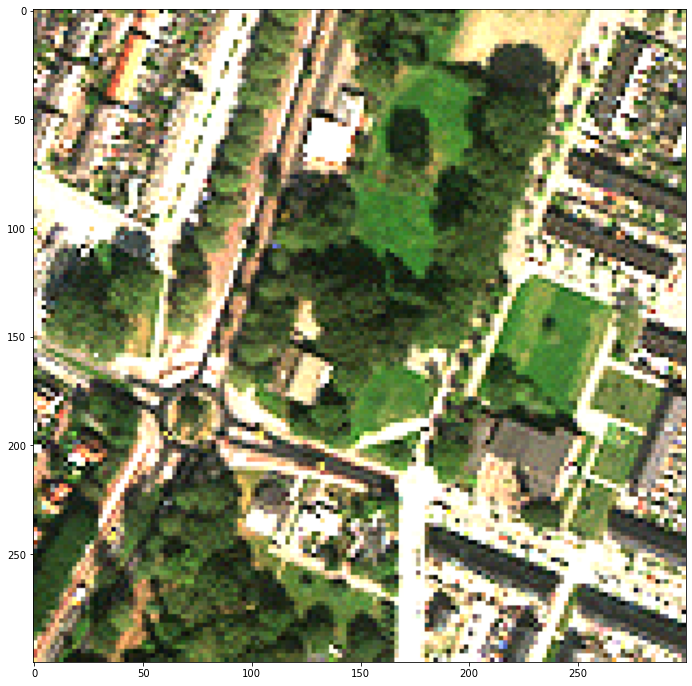

High-res panchromatic image


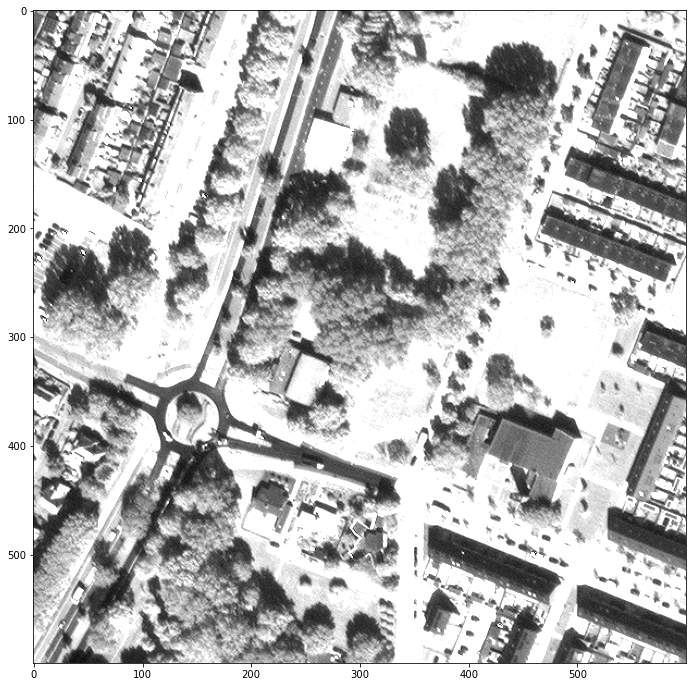

High-res color imagery (pan-sharpened)


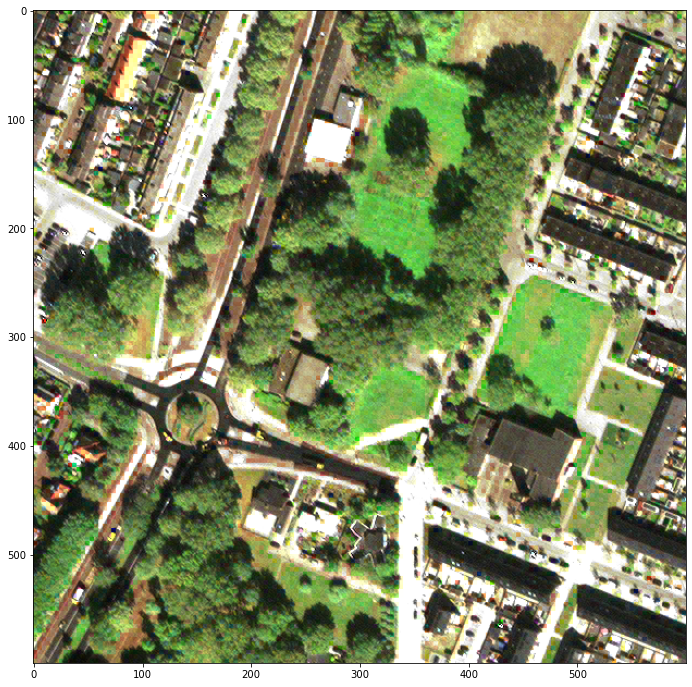

In [14]:
class Pansharpening(pipesegment.PipeSegment):
    def __init__(self, ms_path, pan_path, output_path):
        super().__init__()
        load_ms = image.LoadImage(ms_path) \
            * image.ShowImage(bands=[2,1,0], vmin=0, vmax=250, width=12, caption= 'Low-res color imagery')
        resize_ms = image.Resize(600, 600)
        color_ms = optical.RGBToHSV(rband=2, gband=1, bband=0)
        load_pan = image.LoadImage(pan_path) \
            * image.ShowImage(bands=[0], vmin=0, vmax=250, width=12, caption= 'High-res panchromatic image')
        stack1 = image.MergeToStack()
        get_hs = image.SelectBands((0, 1))
        get_v = sar.BandMath(lambda x: x[3] * np.mean(x[2]) / np.mean(x[3]))
        stack2 = image.MergeToStack()
        color_output = optical.HSVToRGB(hband=0, sband=1, vband=2) \
            * image.ShowImage(vmin=0, vmax=250, width=12, caption= 'High-res color imagery (pan-sharpened)')
        save_output = image.SaveImage(output_path)
        self.feeder = (load_ms * resize_ms * color_ms + load_pan) * stack1 \
            * (get_hs + get_v) * stack2 * color_output# * save_output

ms_path = os.path.join(datadir, 'ms1.tif')
pan_path = os.path.join(datadir, 'pan1.tif')
output_path = os.path.join(datadir, 'output2.tif')
pansharpen = Pansharpening(ms_path, pan_path, output_path)
pansharpen()

The next will use the in-built parallel processing 

In [16]:
#Specify all the file paths
# ms_paths = [os.path.join(datadir, file) for file in ['ms1.tif', 'ms2.tif', 'ms3.tif']]
# pan_paths = [os.path.join(datadir, file) for file in ['pan1.tif', 'pan2.tif', 'pan3.tif']]
# output_paths = [os.path.join(datadir, file) for file in ['output2a.tif', 'output2b.tif', 'output2c.tif']]
# input_args = list(zip(ms_paths, pan_paths, output_paths))
# print(input_args)

# #Run the jobs in parallel
# Pansharpening.parallel(input_args)